In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
#!pip install wordcloud
#!pip install --upgrade pip

In [2]:
import pandas as pd
import numpy as np
import os, sys, time, json, re, string
from operator import add

from pyspark import SparkContext, SparkConf, StorageLevel, keyword_only

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StringType, IntegerType, DoubleType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.param.shared import HasInputCol, HasInputCols, HasOutputCol, HasOutputCols, Param
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, RegexTokenizer, NGram, CountVectorizer, StopWordsRemover
from pyspark.ml.feature import VectorAssembler, PCA

from pyspark.ml.classification import LogisticRegression, NaiveBayes, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml import Pipeline, Transformer

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from wordcloud import WordCloud
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sc

<SparkContext master=yarn appName=PySparkShell>

In [4]:
spark

In [5]:
fakenews_path="gs://dataproc-6ca41800-27b4-47d5-abee-55c011dfa389-asia-southeast1/data/fake-news/"
fakenews_data_path = fakenews_path + "two_million_rows_news_cleaned_2018_02_13_pyspark.csv"

In [6]:
df_news = spark.read.format("com.databricks.spark.csv") \
                    .option("header", "true") \
                    .option("delimiter", '#') \
                    .load(fakenews_data_path)
df_news.printSchema()
df_news = df_news.filter(df_news.type.isin(['conspiracy','clickbait',\
                                                   'reliable','bias','unreliable',\
                                                   'hate','junksci','political',\
                                                   'fake', 'satire', 'rumor']) )
df_news.groupBy('type').count().show()

root
 |-- domain: string (nullable = true)
 |-- type: string (nullable = true)
 |-- url: string (nullable = true)
 |-- content: string (nullable = true)
 |-- scraped_at: string (nullable = true)
 |-- inserted_at: string (nullable = true)
 |-- updated_at: string (nullable = true)
 |-- title: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- meta_keywords: string (nullable = true)
 |-- meta_description: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- source: string (nullable = true)

+----------+------+
|      type| count|
+----------+------+
|conspiracy|111459|
| clickbait| 21741|
|  reliable|  6624|
|      bias|140688|
|unreliable|171357|
|      hate|  3622|
|   junksci| 17488|
| political|292135|
|      fake|123952|
|    satire| 14310|
|     rumor| 67264|
+----------+------+



In [7]:
# text preprocessing steps
tokenizer = RegexTokenizer(inputCol="content", outputCol="all_words", pattern=r"\W")
stopwords_remover = StopWordsRemover(inputCol="all_words", outputCol="words")

df_words = tokenizer.transform(df_news)
df_words = stopwords_remover.transform(df_words)

# cache the dataset with only the needed columns
df_words = df_words.select("type", "words")
df_words.persist(StorageLevel.MEMORY_ONLY)

DataFrame[type: string, words: array<string>]

In [8]:
# utility function to get top frequent words of all the text for a given label
def get_word_freq(df_words, label, column="words", top_n=1000):
    df_word_count = df_words.filter(df_words.type==label).select(column).rdd.flatMap(lambda r: [(w, 1) for w in r[column]]).reduceByKey(add)
    top_wc_list = df_word_count.sortBy(lambda wc: wc[1], ascending=False).take(top_n) 
    return {w.replace(" ", "_"): wc for w, wc in top_wc_list}

# utility function to get top frequent words of all the text for a given label
def get_ngram_freq(df_words, n=2, label='fake', top_n=1000):
    ngram = NGram(inputCol="words", outputCol="ngram", n=n)
    df_ngram = ngram.transform(df_words)
    return get_word_freq(df_ngram, column="ngram", label=label, top_n=top_n)

# utility function to generate and plot wordcloud
def plot_wordcloud(word_freq, max_words=None):
    if max_words is None:
        max_words = len(word_freq) # show all words in the word frequency dict
    # generate wordcloud object
    wc = WordCloud(max_words=max_words, max_font_size=50, background_color="white",
                   width=300, height=300, scale=2).fit_words(word_freq)

    # plot the wordcloud object using matplotlib
    dpi = matplotlib.rcParams['figure.dpi']
    height, width = wc.height * wc.scale, wc.width * wc.scale

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(wc, cmap='gray')

    plt.show()

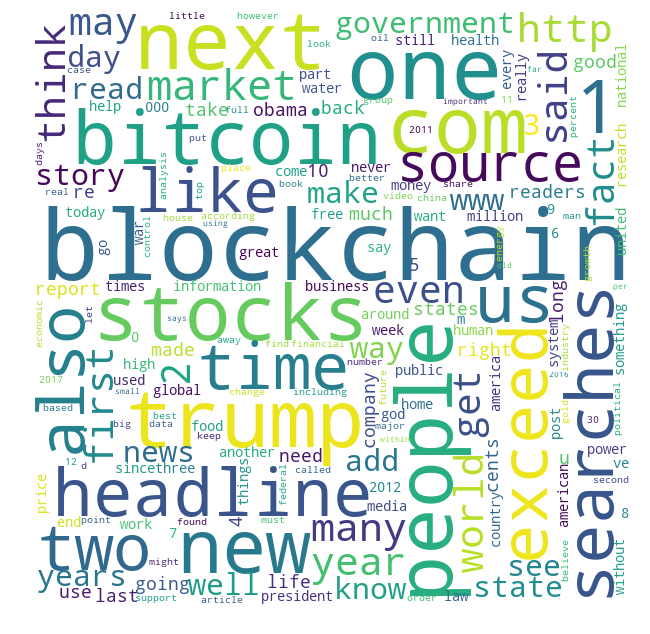

CPU times: user 543 ms, sys: 47.4 ms, total: 591 ms
Wall time: 1min 59s


In [9]:
%%time
wc_top_n = 200
# wordcloud for label 0
plot_wordcloud(get_word_freq(df_words, label='fake', column="words", top_n=wc_top_n), wc_top_n)

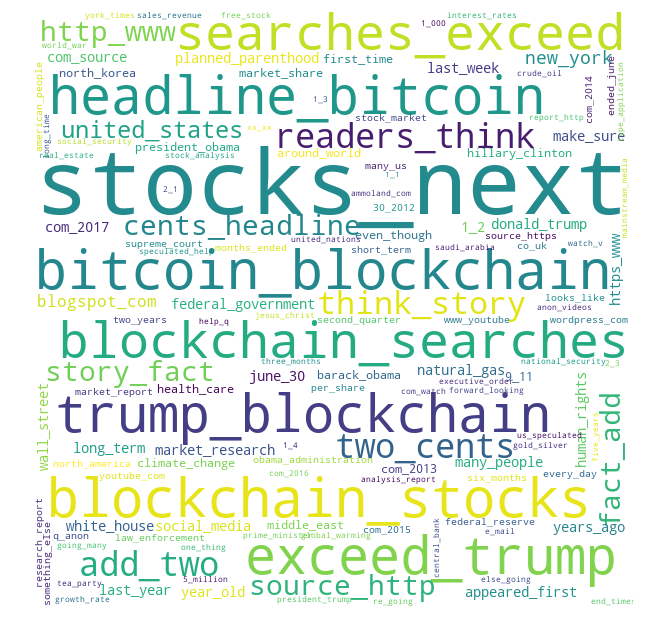

CPU times: user 452 ms, sys: 52.4 ms, total: 504 ms
Wall time: 2min 51s


In [11]:
%%time
# 2gram wordcloud for label 0
plot_wordcloud(get_ngram_freq(df_words, n=2, label='fake', top_n=wc_top_n), wc_top_n)

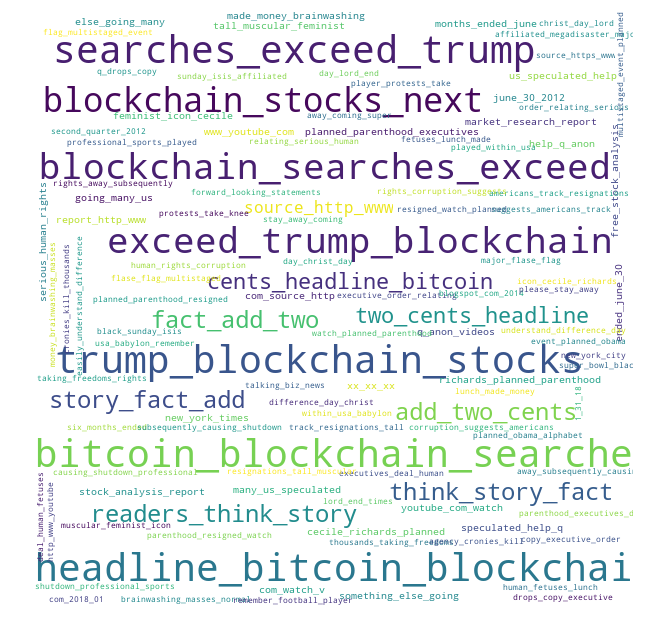

CPU times: user 460 ms, sys: 25.1 ms, total: 485 ms
Wall time: 5min 37s


In [ ]:
%%time
# 3gram wordcloud for label 0
plot_wordcloud(get_ngram_freq(df_words, n=3, label='fake', top_n=wc_top_n), wc_top_n)